In [144]:
# !pip install transformers torch ipywidgets

In [145]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml
from scipy import stats

import torch
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

import warnings
warnings.filterwarnings('ignore')

In [ ]:
config_path = Path("../config/config.yaml")
with open(config_path) as f:
    config = yaml.safe_load(f)

project_root = Path("..").resolve()
FINANCIAL_REPORTS = project_root / config['TABULAR_DATA']
TIME_SERIES = project_root / config['TIMES_SERIES_FOLDER']
NEWS_DIR = project_root / config['NEWS_FOLDER']
GRAPH_DATA = project_root / config['DATA_DICTIONARY']

ticker = config['TICKERS'][0]  # first ticker in list
OUTPUT_PATH = project_root / config['OUTPUT_PATH_DATA']

In [147]:
print(f"\nFinancial Reports: {FINANCIAL_REPORTS}")
if FINANCIAL_REPORTS.exists():
    ticker_dir = FINANCIAL_REPORTS / ticker
    if ticker_dir.exists() and ticker_dir.is_dir():
        print(f"   Found directory: {ticker}/")
        for f in ticker_dir.glob("*.json*"):
            print(f"      - {f.name} ({f.stat().st_size / 1024:.1f} KB)")
    else:
        print(f"   Directory '{ticker}/' not found")
        print(f"   Available directories:")
        for d in list(FINANCIAL_REPORTS.iterdir())[:5]:
            if d.is_dir():
                print(f"      - {d.name}/")

print(f"\nTime Series: {TIME_SERIES}")
if TIME_SERIES.exists():
    for f in list(TIME_SERIES.glob(f"*{ticker}*"))[:5]:
        print(f"Exists: {f.name}")

print(f"\nNews: {NEWS_DIR}")
if NEWS_DIR.exists():
    for f in list(NEWS_DIR.glob(f"*{ticker}*"))[:5]:
        print(f"Exists: {f.name}")

print(f"\Graph: {GRAPH_DATA}")
if GRAPH_DATA.exists():
    for f in list(GRAPH_DATA.glob(f"*{ticker}*"))[:5]:
        print(f"Exists: {f.name}")


Financial Reports: D:\spring-2026-group4\data\multi-modal-dataset\sp500_table
   Found directory: aa/
      - condensed_consolidated_balance_sheets.json (11092.1 KB)
      - condensed_consolidated_statement_of_cash_flows.json (5966.7 KB)
      - condensed_consolidated_statement_of_equity.json (4119.5 KB)

Time Series: D:\spring-2026-group4\data\multi-modal-dataset\sp500_time_series
Exists: aa.csv
Exists: aaau.csv
Exists: aacg.csv
Exists: aadr.csv
Exists: aal.csv

News: D:\spring-2026-group4\data\multi-modal-dataset\sp500_news
Exists: AA.jsonl
Exists: AAAU.jsonl
Exists: AACG.jsonl
Exists: AADR.jsonl
Exists: AAL.jsonl
\Graph: D:\spring-2026-group4\data\multi-modal-dataset\sp500stock_data_description.csv


In [148]:
def load_financial_jsonl(filepath):
    """Load JSON or JSONL file"""
    records = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                try:
                    records.append(json.loads(line))
                except:
                    pass
        
        if not records:
            f.seek(0)
            try:
                data = json.load(f)
                records = data if isinstance(data, list) else [data]
            except:
                pass
    
    return records

In [149]:
ticker_dir = FINANCIAL_REPORTS / ticker
financial_data = {}

if ticker_dir.exists() and ticker_dir.is_dir():
    print(f"\nFound ticker directory: {ticker}/")
    
    json_files = list(ticker_dir.glob("*.json*"))
    
    print(f"Found {len(json_files)} JSON files")
    
    for file in json_files:
        print(f"\nLoading: {file.name}")
        records = load_financial_jsonl(file)
        
        name = file.stem.lower()
        if 'balance' in name:
            key = 'balance_sheet'
        elif 'cash' in name:
            key = 'cash_flow'
        elif 'income' in name:
            key = 'income_statement'
        elif 'equity' in name:
            key = 'equity'
        else:
            key = file.stem  
        
        financial_data[key] = records
        print(f"Loaded records as '{key}'")
else:
    print(f"\nDirectory not found: {ticker_dir}")
    print("\nAvailable ticker directories:")
    for d in sorted(FINANCIAL_REPORTS.iterdir())[:10]:
        if d.is_dir():
            print(f"   - {d.name}/")


Found ticker directory: aa/
Found 3 JSON files

Loading: condensed_consolidated_balance_sheets.json
Loaded records as 'balance_sheet'

Loading: condensed_consolidated_statement_of_cash_flows.json
Loaded records as 'cash_flow'

Loading: condensed_consolidated_statement_of_equity.json
Loaded records as 'equity'


In [150]:
def extract_financial_features(financial_data):
    all_rows = []
    
    for statement_type, records in financial_data.items():
        print(f"\nProcessing {statement_type}...")
        
        for company_record in records:
            cik = company_record.get('cik', '')
            company_name = company_record.get('company_name', '')
            
            for filing in company_record.get('filings', []):
                filing_date = filing.get('filing_date', '')
                form = filing.get('form', '')
                year = filing.get('year', '')
                
                row = {
                    'cik': cik,
                    'company_name': company_name,
                    'statement_type': statement_type,
                    'filing_date': filing_date,
                    'form': form,
                    'year': year
                }
                
                facts = filing.get('facts', {})
                
                for taxonomy, metrics in facts.items():
                    for metric_name, metric_data in metrics.items():
                        
                        col_name = f"{taxonomy}_{metric_name}"
                        
                        if 'units' not in metric_data:
                            continue
                        
                        units = metric_data['units']
                        
                        for unit_type in ['USD', 'shares', 'pure', 'USD/shares']:
                            if unit_type not in units:
                                continue
                            
                            values = units[unit_type]
                            if not values or not isinstance(values, list):
                                continue
                            
                            matched_value = None
                            
                            # Strategy 1: Match by 'filed' date
                            for val_entry in values:
                                if val_entry.get('filed') == filing_date:
                                    matched_value = val_entry.get('val')
                                    break
                            
                            # Strategy 2: If no match, try matching by form and fiscal year
                            if matched_value is None:
                                for val_entry in values:
                                    if (val_entry.get('form') == form and 
                                        str(val_entry.get('fy')) == str(year)):
                                        matched_value = val_entry.get('val')
                                        break
                            
                            # Strategy 3: Match by fiscal period (most recent for this filing)
                            if matched_value is None:
                                valid_values = [
                                    v for v in values 
                                    if v.get('filed', '') <= filing_date
                                ]
                                if valid_values:
                                    matched_value = valid_values[-1].get('val')
                            
                            if matched_value is not None:
                                row[col_name] = matched_value
                                break
                
                all_rows.append(row)
    
    df = pd.DataFrame(all_rows)
    
    if 'filing_date' in df.columns:
        df['filing_date'] = pd.to_datetime(df['filing_date'], errors='coerce')
    
    print(f"\nExtracted DataFrame shape: {df.shape}")
    return df

features_df = extract_financial_features(financial_data)


Processing balance_sheet...

Processing cash_flow...

Processing equity...

Extracted DataFrame shape: (102, 31)


In [151]:
def create_time_series_format(features_df):
    """
    Convert to time series format:
    - Index: filing_date
    - Columns: all metrics
    """
    ts_df = features_df.groupby('filing_date').agg({
        'form': 'first',
        'year': 'first',
        **{col: 'mean' for col in features_df.columns 
           if col.startswith('us-gaap_') or col.startswith('srt_')}
    })
    
    ts_df = ts_df.sort_index()
    
    print(f"Time series shape: {ts_df.shape}")
    print(f"Date range: {ts_df.index.min()} to {ts_df.index.max()}")
    
    return ts_df

ts_features = create_time_series_format(features_df)

Time series shape: (34, 27)
Date range: 2016-12-01 00:00:00 to 2025-02-20 00:00:00


In [152]:
ts_features

,form,year,us-gaap_AccountsPayableCurrent,us-gaap_AccountsReceivableNetCurrent,us-gaap_Assets,us-gaap_AssetsCurrent,us-gaap_CommonStockValue,us-gaap_InventoryNet,us-gaap_Liabilities,us-gaap_LiabilitiesCurrent,...,us-gaap_ProceedsFromSaleOfPropertyPlantAndEquipment,us-gaap_RetainedEarningsAccumulatedDeficit,us-gaap_StockIssuedDuringPeriodValueShareBasedCompensation,us-gaap_StockRepurchaseProgramAuthorizedAmount1,us-gaap_PaymentsRelatedToTaxWithholdingForShareBasedCompensation,us-gaap_StockRepurchaseProgramRemainingAuthorizedRepurchaseAmount1,us-gaap_DividendsCommonStockCash,us-gaap_DividendsPayableAmountPerShare,us-gaap_StockIssuedDuringPeriodSharesShareBasedCompensation,srt_StockRepurchaseProgramAuthorizedAmount1
filing_date,,,,,,,,,,,,,,,,,,,,,
2016-12-01,10-Q,2016,1.379000e+09,380000000.0,1.641300e+10,2.566000e+09,NaN,1.172000e+09,4.900000e+09,2.404000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-15,10-K,2017,1.379000e+09,380000000.0,1.641300e+10,2.566000e+09,2000000.0,1.172000e+09,4.900000e+09,2.404000e+09,...,NaN,-1.040000e+08,10000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-10,10-Q,2017,1.455000e+09,668000000.0,1.674100e+10,3.181000e+09,2000000.0,1.160000e+09,9.044000e+09,2.821000e+09,...,NaN,-1.040000e+08,15000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-03,10-Q,2017,1.455000e+09,668000000.0,1.674100e+10,3.181000e+09,2000000.0,1.160000e+09,9.044000e+09,2.821000e+09,...,NaN,-1.040000e+08,17000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-27,10-Q,2017,1.455000e+09,668000000.0,1.674100e+10,3.181000e+09,2000000.0,1.160000e+09,9.044000e+09,2.821000e+09,...,NaN,-1.040000e+08,37000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-26,10-K,2018,1.455000e+09,668000000.0,1.674100e+10,3.181000e+09,2000000.0,1.160000e+09,9.044000e+09,2.821000e+09,...,NaN,-1.040000e+08,10000000.0,200000000.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-09,10-Q,2018,1.898000e+09,811000000.0,1.744700e+10,4.238000e+09,2000000.0,1.453000e+09,1.064900e+10,3.252000e+09,...,NaN,1.130000e+08,15000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-02,10-Q,2018,1.898000e+09,811000000.0,1.744700e+10,4.238000e+09,2000000.0,1.453000e+09,1.064900e+10,3.252000e+09,...,NaN,1.130000e+08,17000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-02,10-Q,2018,1.898000e+09,811000000.0,1.744700e+10,4.238000e+09,2000000.0,1.453000e+09,1.064900e+10,3.252000e+09,...,NaN,1.130000e+08,37000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [153]:
ts_files = list(TIME_SERIES.glob(f"*{ticker}*.csv"))

if not ts_files:
    ts_files = list(TIME_SERIES.glob(f"*{ticker.upper()}*.csv"))

if ts_files:
    ts_file = ts_files[0]
    print(f"\nLoading: {ts_file.name}")
    
    ts_data = pd.read_csv(ts_file)
    
    date_col = None
    for col in ts_data.columns:
        if 'date' in col.lower():
            date_col = col
            ts_data[col] = pd.to_datetime(ts_data[col])
            break
    
    if date_col:
        ts_data = ts_data.sort_values(date_col)
    
    print(f"Loaded {len(ts_data)} records")
    print(f"Columns: {list(ts_data.columns)}")
    
    if date_col:
        print(f"   Date range: {ts_data[date_col].min()} to {ts_data[date_col].max()}")
    
    print("\n   First few rows:")
    print(ts_data.head())
else:
    ts_data = None
    print(f"\nNo time series file found for '{ticker}'")
    print("\n   Available files:")
    for f in list(TIME_SERIES.glob("*.csv"))[:5]:
        print(f"      - {f.name}")


Loading: aa.csv
Loaded 6348 records
Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
   Date range: 2000-01-03 00:00:00-05:00 to 2025-03-28 00:00:00-04:00

   First few rows:
                        Date       Open       High        Low      Close  \
0  2000-01-03 00:00:00-05:00  71.417944  71.901950  69.159243  69.643250   
1  2000-01-04 00:00:00-05:00  69.643272  70.396174  69.105485  69.965942   
2  2000-01-05 00:00:00-05:00  69.965897  74.429516  69.697006  73.999290   
3  2000-01-06 00:00:00-05:00  73.999337  74.322007  72.977544  73.031319   
4  2000-01-07 00:00:00-05:00  73.031310  74.752225  72.762420  72.816200   

    Volume  Dividends  Stock Splits  
0  1291386        0.0           0.0  
1  1860008        0.0           0.0  
2  2598086        0.0           0.0  
3  3740907        0.0           0.0  
4  3774199        0.0           0.0  


In [154]:
def merge_daily_with_financials(ts_data, date_col, financial_df, ticker):
    """
    Merge daily OHLCV with quarterly financial data
    Financial features are forward-filled to all days until next filing
    """
    ts_data = ts_data.copy()
    
    fin_ticker = financial_df[financial_df['company_name'].str.lower() == ticker.lower()].copy()
    
    if fin_ticker.empty:
        print(f"No financial data found for {ticker}")
        return ts_data
    
    ts_data[date_col] = pd.to_datetime(ts_data[date_col], errors='coerce')
    fin_ticker['filing_date'] = pd.to_datetime(fin_ticker['filing_date'], errors='coerce')
    
    if ts_data[date_col].dt.tz is not None:
        ts_data[date_col] = ts_data[date_col].dt.tz_localize(None)
    
    if fin_ticker['filing_date'].dt.tz is not None:
        fin_ticker['filing_date'] = fin_ticker['filing_date'].dt.tz_localize(None)
    
    ts_data = ts_data.dropna(subset=[date_col])
    fin_ticker = fin_ticker.dropna(subset=['filing_date'])
    
    ts_data = ts_data.sort_values(date_col).reset_index(drop=True)
    fin_ticker = fin_ticker.sort_values('filing_date').reset_index(drop=True)
    
    print(f"\n{'='*60}")
    print(f"MERGING DATA FOR {ticker.upper()}")
    print(f"{'='*60}")
    print(f"Daily records: {len(ts_data):,}")
    print(f"Financial filings: {len(fin_ticker)}")
    print(f"Date types: TS={ts_data[date_col].dtype}, Fin={fin_ticker['filing_date'].dtype}")
    
    merged = pd.merge_asof(
        ts_data,
        fin_ticker,
        left_on=date_col,
        right_on='filing_date',
        direction='backward'
    )
    
    fin_cols = [col for col in merged.columns if col.startswith('us-gaap_')]
    has_fin_data = merged[fin_cols].notna().any(axis=1).sum()
    
    print(f"\nMerge complete!")
    print(f"   Total rows: {len(merged):,}")
    print(f"   Days with financial data: {has_fin_data:,} ({has_fin_data/len(merged)*100:.1f}%)")
    print(f"   Days without financial data: {len(merged)-has_fin_data:,}")
    
    print(f"\nSample merged data:")
    sample_cols = [date_col, 'Close', 'us-gaap_Assets', 'us-gaap_StockholdersEquity', 'filing_date']
    sample_cols = [c for c in sample_cols if c in merged.columns]
    print(merged[sample_cols].head(10))
    
    return merged


if ts_data is not None:
    merged_data = merge_daily_with_financials(
        ts_data=ts_data,
        date_col=date_col,
        financial_df=features_df,
        ticker=ticker
    )
else:
    print("No time series data to merge")


MERGING DATA FOR AA
Daily records: 2,341
Financial filings: 102
Date types: TS=datetime64[ns], Fin=datetime64[ns]

Merge complete!
   Total rows: 2,341
   Days with financial data: 752 (32.1%)
   Days without financial data: 1,589

Sample merged data:
        Date      Close  us-gaap_Assets  us-gaap_StockholdersEquity  \
0 2000-01-03  69.643250             NaN                         NaN   
1 2000-01-04  69.965942             NaN                         NaN   
2 2000-01-05  73.999290             NaN                         NaN   
3 2000-01-06  73.031319             NaN                         NaN   
4 2000-01-07  72.816200             NaN                         NaN   
5 2000-01-10  72.601089             NaN                         NaN   
6 2000-01-11  72.170799             NaN                         NaN   
7 2000-01-12  71.525528             NaN                         NaN   
8 2000-01-13  70.234833             NaN                         NaN   
9 2000-01-14  68.836563             N

In [155]:
merged_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,cik,company_name,...,us-gaap_ProceedsFromSaleOfPropertyPlantAndEquipment,us-gaap_RetainedEarningsAccumulatedDeficit,us-gaap_StockIssuedDuringPeriodValueShareBasedCompensation,us-gaap_StockRepurchaseProgramAuthorizedAmount1,us-gaap_PaymentsRelatedToTaxWithholdingForShareBasedCompensation,us-gaap_StockRepurchaseProgramRemainingAuthorizedRepurchaseAmount1,us-gaap_DividendsCommonStockCash,us-gaap_DividendsPayableAmountPerShare,us-gaap_StockIssuedDuringPeriodSharesShareBasedCompensation,srt_StockRepurchaseProgramAuthorizedAmount1
0,2000-01-03,71.417944,71.901950,69.159243,69.643250,1291386,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-04,69.643272,70.396174,69.105485,69.965942,1860008,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-05,69.965897,74.429516,69.697006,73.999290,2598086,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01-06,73.999337,74.322007,72.977544,73.031319,3740907,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01-07,73.031310,74.752225,72.762420,72.816200,3774199,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
merged_data.shape

(2341, 39)

In [157]:
merged_data.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,cik,company_name,...,us-gaap_ProceedsFromSaleOfPropertyPlantAndEquipment,us-gaap_RetainedEarningsAccumulatedDeficit,us-gaap_StockIssuedDuringPeriodValueShareBasedCompensation,us-gaap_StockRepurchaseProgramAuthorizedAmount1,us-gaap_PaymentsRelatedToTaxWithholdingForShareBasedCompensation,us-gaap_StockRepurchaseProgramRemainingAuthorizedRepurchaseAmount1,us-gaap_DividendsCommonStockCash,us-gaap_DividendsPayableAmountPerShare,us-gaap_StockIssuedDuringPeriodSharesShareBasedCompensation,srt_StockRepurchaseProgramAuthorizedAmount1
2336,2025-03-03,34.389881,34.399848,31.200095,31.230000,4994500,0.0,0.0,0001675149,aa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2337,2025-03-04,31.355000,31.860001,30.150000,31.150000,5231800,0.1,0.0,0001675149,aa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2338,2025-03-05,32.480000,32.680000,31.601999,32.380001,4520500,0.0,0.0,0001675149,aa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2339,2025-03-06,32.400002,33.840000,32.279999,32.830002,5857200,0.0,0.0,0001675149,aa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2340,2025-03-07,32.250000,33.380001,31.834999,32.840000,4178800,0.0,0.0,0001675149,aa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
def load_and_process_news(news_file, ticker):
    """
    Load news JSONL and prepare for merging with daily data
    Aggregates multiple articles per day into a list
    """
    print(f"\n{'='*60}")
    print(f"LOADING NEWS DATA FOR {ticker.upper()}")
    print(f"{'='*60}")
    
    articles = []
    with open(news_file, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                try:
                    articles.append(json.loads(line))
                except:
                    pass
    
    news_df = pd.DataFrame(articles)
    print(f"Loaded {len(news_df)} articles")
    print(f"Columns: {list(news_df.columns)}")
    
    news_df['Date'] = pd.to_datetime(news_df['Date'], errors='coerce')
    if news_df['Date'].dt.tz is not None:
        news_df['Date'] = news_df['Date'].dt.tz_localize(None)
    
    news_df = news_df.dropna(subset=['Date'])
    
    print(f"Date range: {news_df['Date'].min()} to {news_df['Date'].max()}")
    
    news_agg = news_df.groupby('Date').agg(
        news_count=('Article', 'count'),
        news_avg_length=('Article', lambda x: x.str.len().mean()),
        news_articles_list=('Article', lambda x: x.dropna().tolist())
    ).reset_index()
    
    news_agg = news_agg.rename(columns={'Date': 'date'})
    
    print(f"\nAggregated to {len(news_agg)} unique dates")
    print(f"Average articles per day: {news_df.groupby('Date').size().mean():.1f}")
    
    print(f"\nSample aggregated data:")
    print(news_agg[['date', 'news_count', 'news_avg_length']].head())
    
    print(f"\nExample list for first day:")
    first_list = news_agg.iloc[0]['news_articles_list']
    print(f"Date: {news_agg.iloc[0]['date']}")
    print(f"Number of articles: {len(first_list)}")
    print(f"First article preview: {first_list[0][:200]}...")
    
    return news_agg


news_files = list(NEWS_DIR.glob(f"*{ticker.upper()}*.jsonl"))

if news_files:
    news_file = news_files[0]
    print(f"Found: {news_file.name}")
    news_aggregated = load_and_process_news(news_file, ticker)
else:
    news_aggregated = None
    print(f"No news file found for {ticker}")

Found: AA.jsonl

LOADING NEWS DATA FOR AA
Loaded 1865 articles
Columns: ['Date', 'Url', 'Article', 'Stock_symbol', 'Article_title']
Date range: 2009-10-07 00:00:00 to 2025-04-21 00:00:00

Aggregated to 1054 unique dates
Average articles per day: 1.8

Sample aggregated data:
        date  news_count  news_avg_length
0 2009-10-07           1           3112.0
1 2009-10-09           1           1539.0
2 2009-10-14           1           3791.0
3 2009-11-04           1           2486.0
4 2009-12-02           1           5942.0

Example list for first day:
Date: 2009-10-07 00:00:00
Number of articles: 1
First article preview: Adobe ( ADBE ) recently announced its Q4 2010 earnings and highlighted the importance of mobile devices like tablets for its future growth. Although Apple does not currently support Flash, Google's ( ...


In [159]:
def merge_with_news(merged_data, news_agg, date_col):
    """
    Add news features to the merged dataset
    news_articles_list will contain a list of article texts for each day
    """
    if news_agg is None or news_agg.empty:
        print("No news data to merge")
        return merged_data
    
    print(f"\n{'='*60}")
    print("MERGING NEWS DATA")
    print(f"{'='*60}")
    
    merged_with_news = merged_data.copy()
    
    merged_with_news[date_col] = pd.to_datetime(merged_with_news[date_col])
    if merged_with_news[date_col].dt.tz is not None:
        merged_with_news[date_col] = merged_with_news[date_col].dt.tz_localize(None)
    
    news_agg['date'] = pd.to_datetime(news_agg['date'])
    if news_agg['date'].dt.tz is not None:
        news_agg['date'] = news_agg['date'].dt.tz_localize(None)
    
    print(f"Before merge: {merged_with_news.shape}")
    print(f"News records: {len(news_agg)}")
    
    final = merged_with_news.merge(
        news_agg,
        left_on=date_col,
        right_on='date',
        how='left'
    )
    
    if 'date' in final.columns and date_col != 'date':
        final = final.drop(columns=['date'])
    
    final['news_count'] = final['news_count'].fillna(0).astype(int)
    
    final['news_articles_list'] = final['news_articles_list'].apply(
        lambda x: x if isinstance(x, list) else []
    )
    
    days_with_news = (final['news_count'] > 0).sum()
    
    print(f"\nMerge complete!")
    print(f"   Final shape: {final.shape}")
    print(f"   Days with news: {days_with_news:,} ({days_with_news/len(final)*100:.1f}%)")
    print(f"   Days without news: {len(final)-days_with_news:,}")
    
    print(f"\nSample with news data:")
    sample_cols = [date_col, 'Close', 'news_count', 'news_avg_length']
    sample_cols = [c for c in sample_cols if c in final.columns]
    print(final[sample_cols].head(10))
    
    return final


if 'merged_data' in locals() and news_aggregated is not None:
    final_merged = merge_with_news(merged_data, news_aggregated, date_col)
else:
    print("Missing merged_data or news_aggregated")


MERGING NEWS DATA
Before merge: (2341, 39)
News records: 1054

Merge complete!
   Final shape: (2341, 42)
   Days with news: 315 (13.5%)
   Days without news: 2,026

Sample with news data:
        Date      Close  news_count  news_avg_length
0 2000-01-03  69.643250           0              NaN
1 2000-01-04  69.965942           0              NaN
2 2000-01-05  73.999290           0              NaN
3 2000-01-06  73.031319           0              NaN
4 2000-01-07  72.816200           0              NaN
5 2000-01-10  72.601089           0              NaN
6 2000-01-11  72.170799           0              NaN
7 2000-01-12  71.525528           0              NaN
8 2000-01-13  70.234833           0              NaN
9 2000-01-14  68.836563           0              NaN


In [160]:
print(final_merged)

           Date       Open       High        Low      Close   Volume  \
0    2000-01-03  71.417944  71.901950  69.159243  69.643250  1291386   
1    2000-01-04  69.643272  70.396174  69.105485  69.965942  1860008   
2    2000-01-05  69.965897  74.429516  69.697006  73.999290  2598086   
3    2000-01-06  73.999337  74.322007  72.977544  73.031319  3740907   
4    2000-01-07  73.031310  74.752225  72.762420  72.816200  3774199   
...         ...        ...        ...        ...        ...      ...   
2336 2025-03-03  34.389881  34.399848  31.200095  31.230000  4994500   
2337 2025-03-04  31.355000  31.860001  30.150000  31.150000  5231800   
2338 2025-03-05  32.480000  32.680000  31.601999  32.380001  4520500   
2339 2025-03-06  32.400002  33.840000  32.279999  32.830002  5857200   
2340 2025-03-07  32.250000  33.380001  31.834999  32.840000  4178800   

      Dividends  Stock Splits         cik company_name  ...  \
0           0.0           0.0         NaN          NaN  ...   
1        

In [161]:
print(final_merged.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'cik', 'company_name', 'statement_type', 'filing_date',
       'form', 'year', 'us-gaap_AccountsPayableCurrent',
       'us-gaap_AccountsReceivableNetCurrent', 'us-gaap_Assets',
       'us-gaap_AssetsCurrent', 'us-gaap_CommonStockValue',
       'us-gaap_InventoryNet', 'us-gaap_Liabilities',
       'us-gaap_LiabilitiesCurrent', 'us-gaap_PropertyPlantAndEquipmentNet',
       'us-gaap_StockholdersEquity',
       'us-gaap_CashAndCashEquivalentsPeriodIncreaseDecrease',
       'us-gaap_NetCashProvidedByUsedInFinancingActivities',
       'us-gaap_NetCashProvidedByUsedInInvestingActivities',
       'us-gaap_NetCashProvidedByUsedInOperatingActivities',
       'us-gaap_PaymentsToAcquirePropertyPlantAndEquipment',
       'us-gaap_ProceedsFromSaleOfPropertyPlantAndEquipment',
       'us-gaap_RetainedEarningsAccumulatedDeficit',
       'us-gaap_StockIssuedDuringPeriodValueShareBasedCompensation',
       'us

In [162]:
sector_df = pd.read_csv(GRAPH_DATA)
sector_df.head()

,stock_name,Sector,table,image,ts,text,Unnamed: 6,"Note: A value of 1 in the table, image, ts, or text columns indicates the corresponding modality data exists; otherwise, it does not."
0,aa,Basic Materials,1,1,1,1,NaN,NaN
1,aem,Basic Materials,1,1,1,1,NaN,NaN
2,ag,Basic Materials,1,1,1,1,NaN,NaN
3,agi,Basic Materials,1,1,1,1,NaN,NaN
4,alb,Basic Materials,1,1,1,1,NaN,NaN


In [163]:
print(sector_df.columns)

Index(['stock_name', 'Sector', 'table', 'image', 'ts', 'text', 'Unnamed: 6',
       'Note: A value of 1 in the table, image, ts, or text columns indicates the corresponding modality data exists; otherwise, it does not.'],
      dtype='object')


In [164]:
# Config
history_window_size = 30
forecast_horizon = 5
stride = 1

In [165]:
final_merged['Date'] = pd.to_datetime(final_merged['Date'])
final_merged = final_merged.sort_values('Date').reset_index(drop=True)
sector_map = dict(zip(sector_df['stock_name'], sector_df['Sector']))

ts_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
table_cols = ['cik', 'company_name', 'statement_type', 'filing_date', 'form', 'year',
              'us-gaap_AccountsPayableCurrent', 'us-gaap_AccountsReceivableNetCurrent',
              'us-gaap_Assets', 'us-gaap_AssetsCurrent', 'us-gaap_CommonStockValue',
              'us-gaap_InventoryNet', 'us-gaap_Liabilities', 'us-gaap_LiabilitiesCurrent',
              'us-gaap_PropertyPlantAndEquipmentNet', 'us-gaap_StockholdersEquity',
              'us-gaap_CashAndCashEquivalentsPeriodIncreaseDecrease',
              'us-gaap_NetCashProvidedByUsedInFinancingActivities',
              'us-gaap_NetCashProvidedByUsedInInvestingActivities',
              'us-gaap_NetCashProvidedByUsedInOperatingActivities',
              'us-gaap_PaymentsToAcquirePropertyPlantAndEquipment',
              'us-gaap_ProceedsFromSaleOfPropertyPlantAndEquipment',
              'us-gaap_RetainedEarningsAccumulatedDeficit',
              'us-gaap_StockIssuedDuringPeriodValueShareBasedCompensation',
              'us-gaap_StockRepurchaseProgramAuthorizedAmount1',
              'us-gaap_PaymentsRelatedToTaxWithholdingForShareBasedCompensation',
              'us-gaap_StockRepurchaseProgramRemainingAuthorizedRepurchaseAmount1',
              'us-gaap_DividendsCommonStockCash', 'us-gaap_DividendsPayableAmountPerShare',
              'us-gaap_StockIssuedDuringPeriodSharesShareBasedCompensation',
              'srt_StockRepurchaseProgramAuthorizedAmount1']

In [166]:
samples = []
total = history_window_size + forecast_horizon
sector = sector_map.get(ticker, 'Unknown')

for i in range(0, len(final_merged) - total + 1, stride):
    window = final_merged.iloc[i:i + history_window_size]
    future = final_merged.iloc[i + history_window_size:i + total]
    
    sample = {
        "dates": window['Date'].dt.strftime('%Y-%m-%d').tolist(),
"articles": [None if not isinstance(x, list) or len(x) == 0 else x for x in window['news_articles_list']],
        "time_series": [{col.lower(): (None if pd.isna(row[col]) else float(row[col])) 
                         for col in ts_cols} for _, row in window.iterrows()],
        "table_data": [{col: (None if col not in window.columns or pd.isna(row[col]) 
                      else str(row[col]) if isinstance(row[col], pd.Timestamp)
                      else float(row[col]) if isinstance(row[col], (np.integer, np.floating)) 
                      else row[col]) for col in table_cols} for _, row in window.iterrows()],
        "sector": sector,
        "target": [None if pd.isna(x) else float(x) for x in future['Close']]
    }
    samples.append(sample)

In [167]:
output_file = OUTPUT_PATH / f"{ticker}.jsonl"
output_file.parent.mkdir(parents=True, exist_ok=True)
with open(output_file, 'w') as f:
    for sample in samples:
        f.write(json.dumps(sample) + '\n')

print(f"Created {len(samples)} samples to {output_file}")

Created 2307 samples to D:\spring-2026-group4\data\baseline_data\aa.jsonl


In [168]:
print("DATASET OVERVIEW")
print("="*70)
print(f"\nShape: {final_merged.shape}")
print(f"Date range: {final_merged['Date'].min()} to {final_merged['Date'].max()}")
print(f"Total days: {len(final_merged)}")
print(f"\nMissing values:")
print(final_merged.isnull().sum()[final_merged.isnull().sum() > 0].sort_values(ascending=False))

print(f"\nPrice statistics:")
print(final_merged[['Open', 'High', 'Low', 'Close', 'Volume']].describe())

DATASET OVERVIEW

Shape: (2341, 42)
Date range: 2000-01-03 00:00:00 to 2025-03-07 00:00:00
Total days: 2341

Missing values:
srt_StockRepurchaseProgramAuthorizedAmount1                           2341
us-gaap_StockIssuedDuringPeriodSharesShareBasedCompensation           2341
us-gaap_DividendsPayableAmountPerShare                                2341
us-gaap_StockRepurchaseProgramRemainingAuthorizedRepurchaseAmount1    2341
us-gaap_DividendsCommonStockCash                                      2329
us-gaap_PaymentsRelatedToTaxWithholdingForShareBasedCompensation      2329
us-gaap_StockRepurchaseProgramAuthorizedAmount1                       2318
us-gaap_RetainedEarningsAccumulatedDeficit                            2243
us-gaap_StockIssuedDuringPeriodValueShareBasedCompensation            2243
us-gaap_ProceedsFromSaleOfPropertyPlantAndEquipment                   2093
us-gaap_NetCashProvidedByUsedInInvestingActivities                    2093
us-gaap_NetCashProvidedByUsedInFinancingActivities

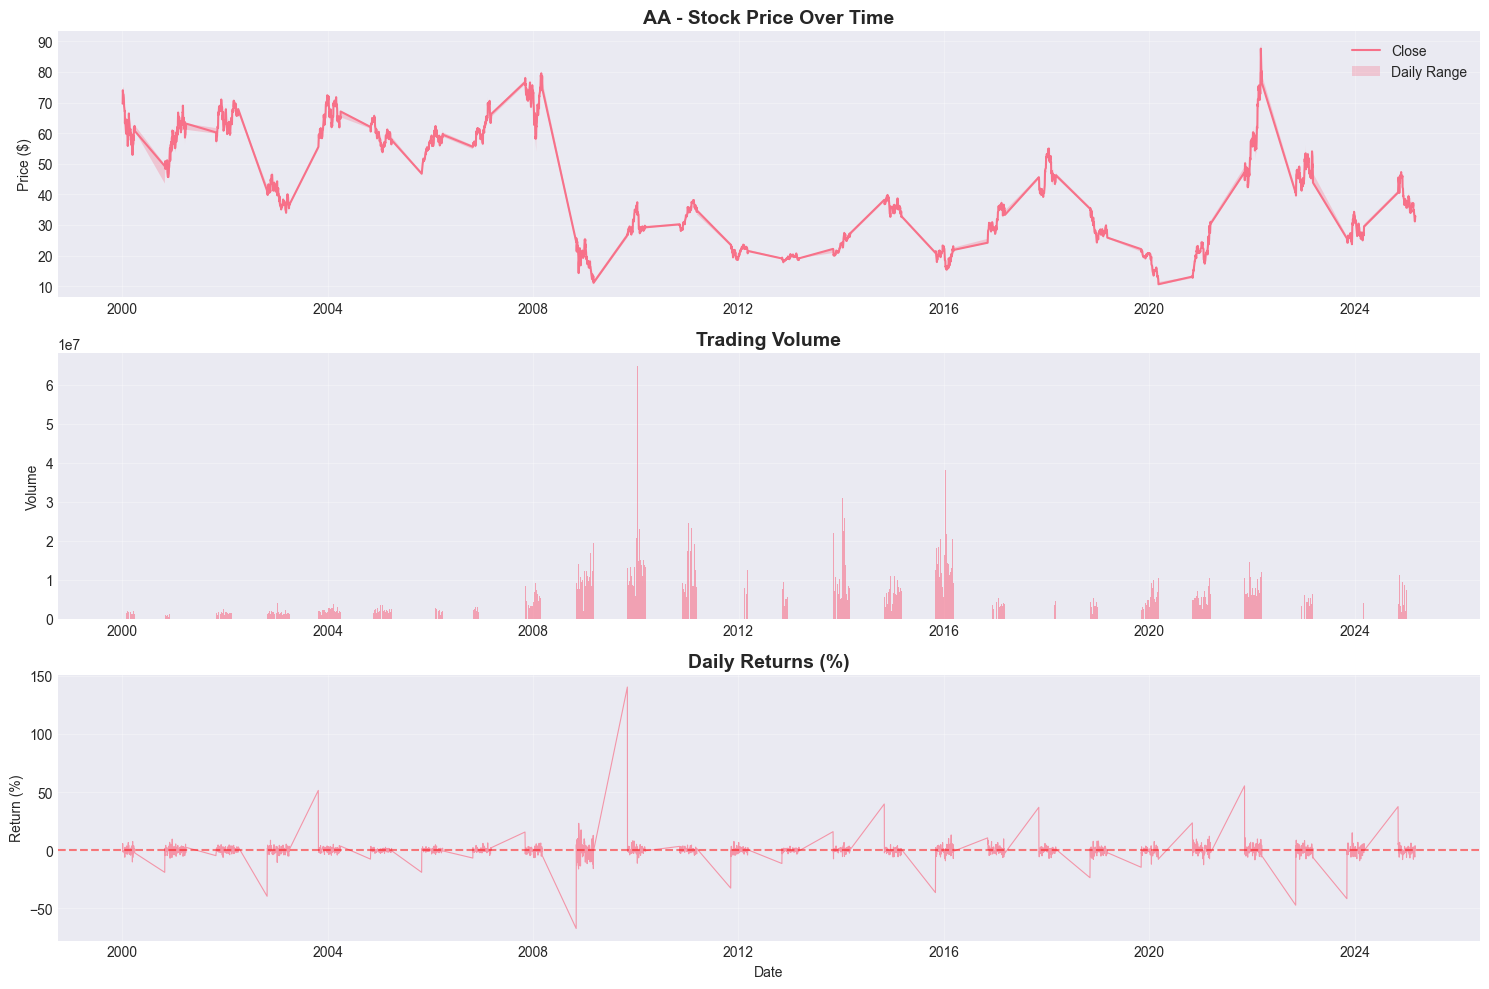

In [169]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Price
axes[0].plot(final_merged['Date'], final_merged['Close'], label='Close', linewidth=1.5)
axes[0].fill_between(final_merged['Date'], final_merged['Low'], final_merged['High'], 
                      alpha=0.3, label='Daily Range')
axes[0].set_title(f'{ticker.upper()} - Stock Price Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Volume
axes[1].bar(final_merged['Date'], final_merged['Volume'], width=1, alpha=0.6)
axes[1].set_title('Trading Volume', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Volume')
axes[1].grid(True, alpha=0.3)

# Returns
final_merged['Returns'] = final_merged['Close'].pct_change() * 100
axes[2].plot(final_merged['Date'], final_merged['Returns'], linewidth=0.8, alpha=0.7)
axes[2].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[2].set_title('Daily Returns (%)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Return (%)')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

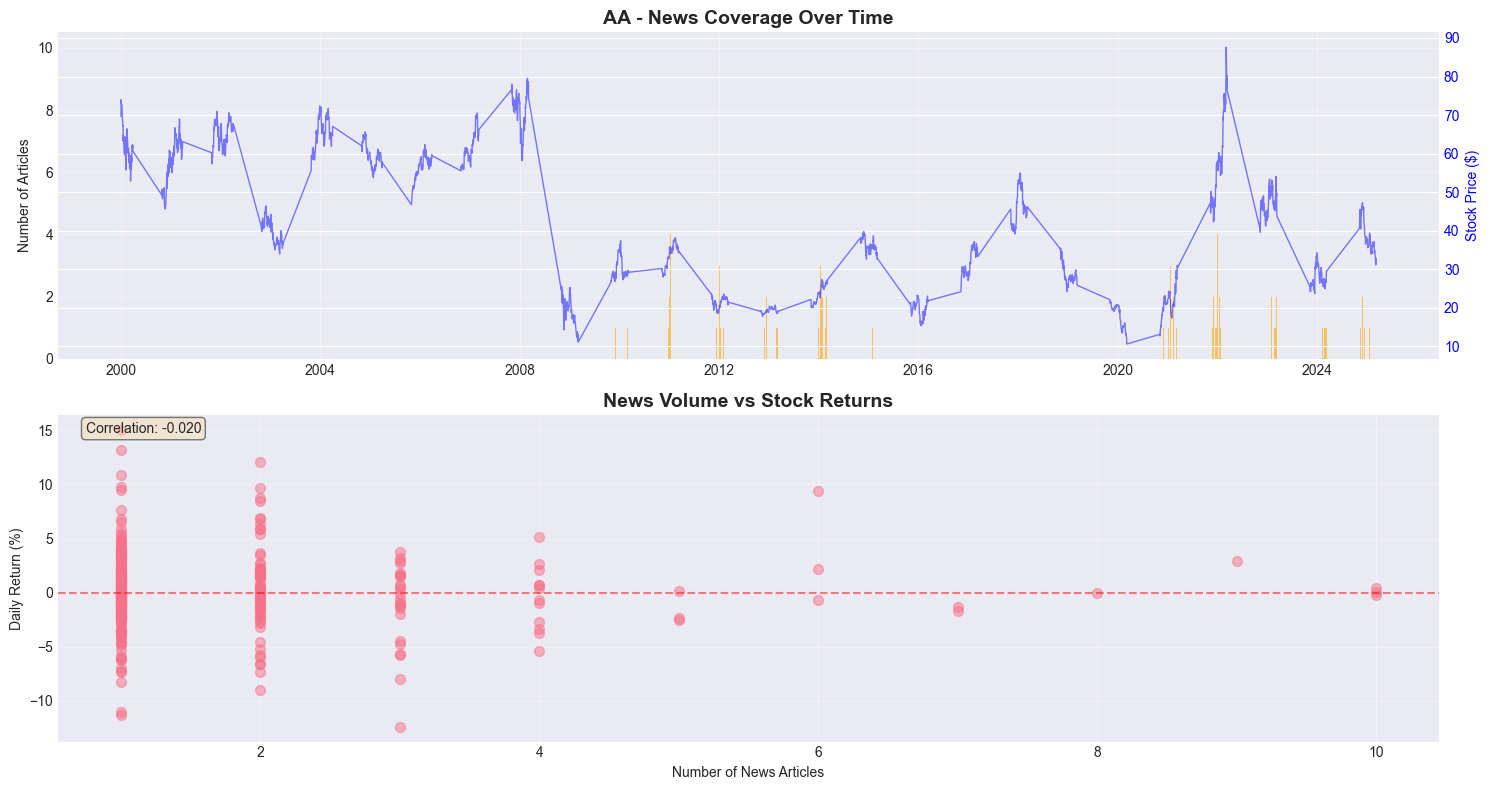

In [170]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# News count over time
axes[0].bar(final_merged['Date'], final_merged['news_count'], width=1, alpha=0.6, color='orange')
axes[0].set_title(f'{ticker.upper()} - News Coverage Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Articles')
axes[0].grid(True, alpha=0.3)

# Price with news overlay
ax2 = axes[0].twinx()
ax2.plot(final_merged['Date'], final_merged['Close'], color='blue', alpha=0.5, linewidth=1)
ax2.set_ylabel('Stock Price ($)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# News vs Returns scatter
news_days = final_merged[final_merged['news_count'] > 0].copy()
axes[1].scatter(news_days['news_count'], news_days['Returns'], 
                alpha=0.5, s=50)
axes[1].set_xlabel('Number of News Articles')
axes[1].set_ylabel('Daily Return (%)')
axes[1].set_title('News Volume vs Stock Returns', fontsize=14, fontweight='bold')
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)

# Add correlation
if len(news_days) > 0:
    corr = news_days[['news_count', 'Returns']].corr().iloc[0, 1]
    axes[1].text(0.02, 0.98, f'Correlation: {corr:.3f}', 
                 transform=axes[1].transAxes, 
                 verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

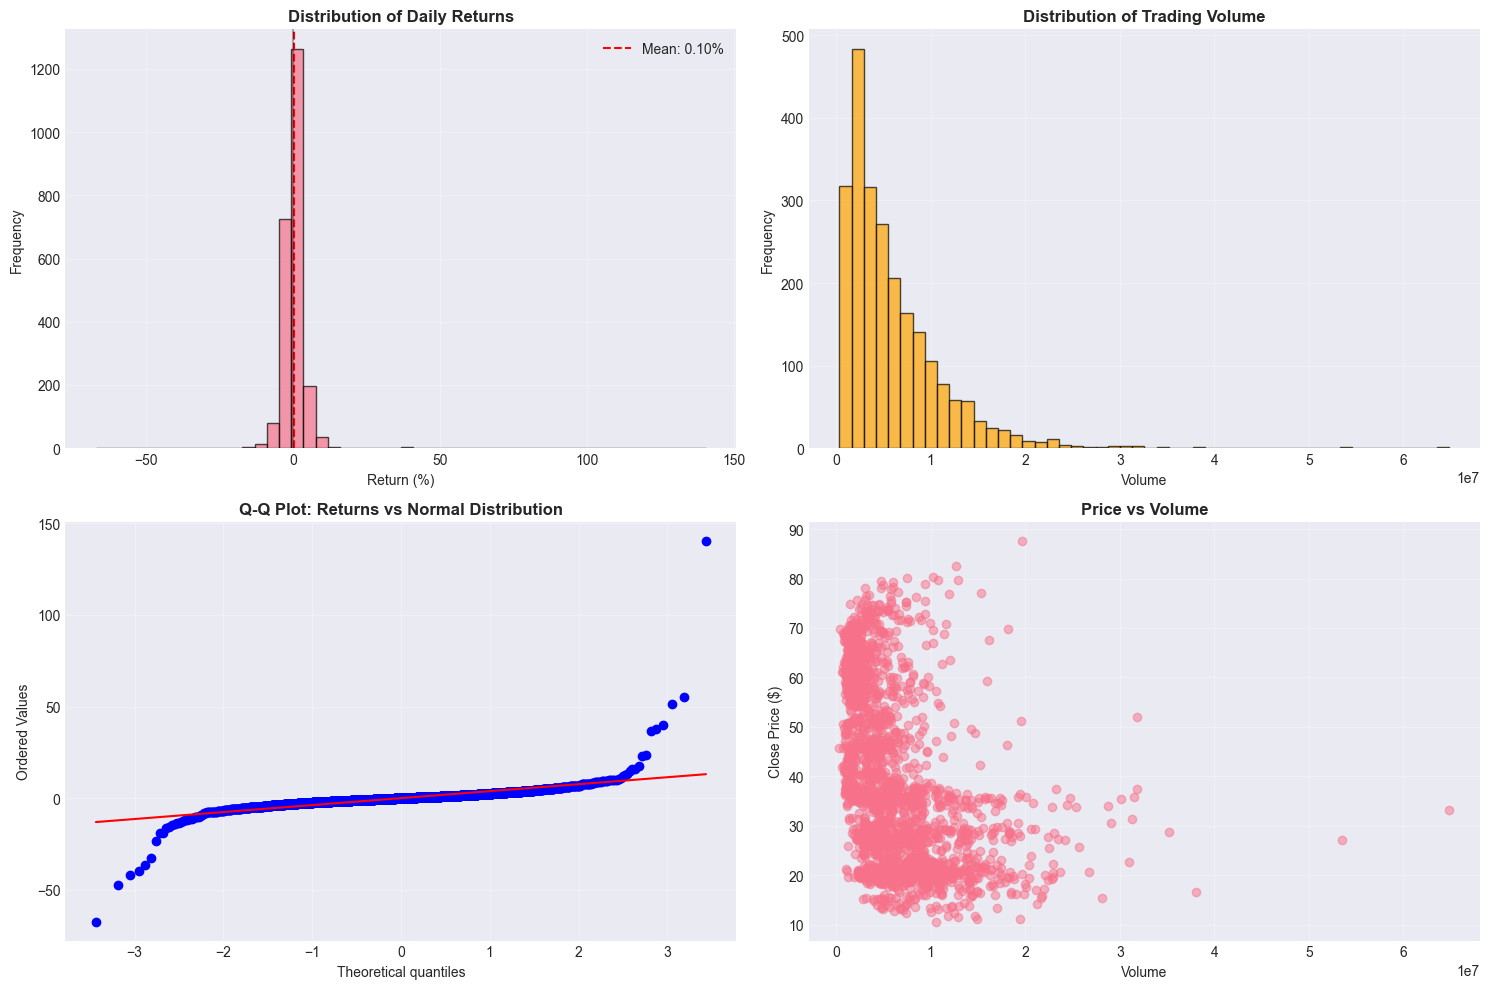

In [173]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Returns distribution
axes[0, 0].hist(final_merged['Returns'].dropna(), bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(final_merged['Returns'].mean(), color='r', 
                   linestyle='--', label=f'Mean: {final_merged["Returns"].mean():.2f}%')
axes[0, 0].axvline(0, color='black', linestyle='-', alpha=0.3)
axes[0, 0].set_title('Distribution of Daily Returns', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Return (%)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Volume distribution
axes[0, 1].hist(final_merged['Volume'], bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[0, 1].set_title('Distribution of Trading Volume', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Volume')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plot for returns
stats.probplot(final_merged['Returns'].dropna(), dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot: Returns vs Normal Distribution', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Price vs Volume scatter
axes[1, 1].scatter(final_merged['Volume'], final_merged['Close'], alpha=0.5)
axes[1, 1].set_xlabel('Volume')
axes[1, 1].set_ylabel('Close Price ($)')
axes[1, 1].set_title('Price vs Volume', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

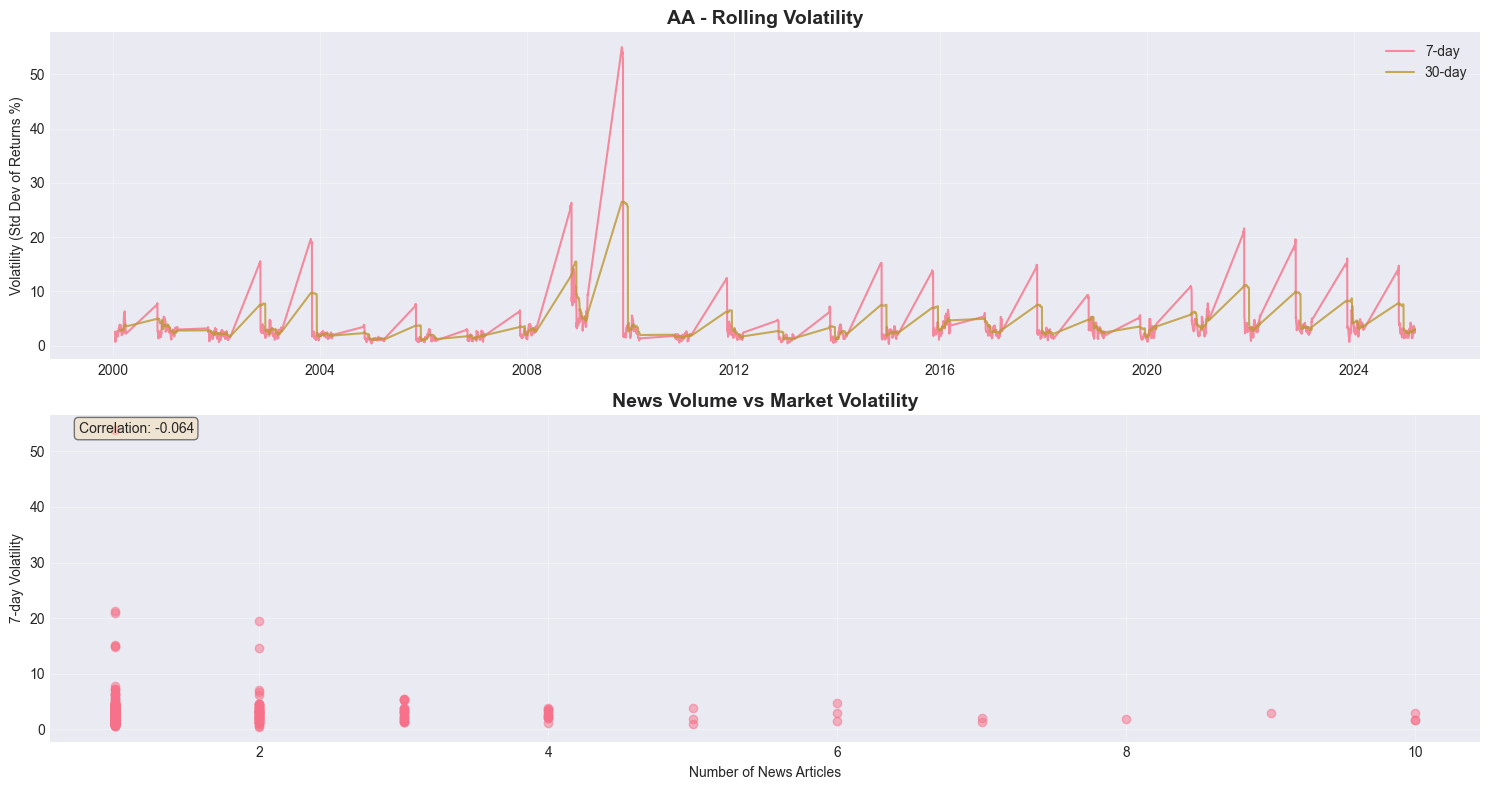

In [174]:
final_merged['Volatility_7d'] = final_merged['Returns'].rolling(window=7).std()
final_merged['Volatility_30d'] = final_merged['Returns'].rolling(window=30).std()

fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Volatility over time
axes[0].plot(final_merged['Date'], final_merged['Volatility_7d'], 
             label='7-day', linewidth=1.5, alpha=0.8)
axes[0].plot(final_merged['Date'], final_merged['Volatility_30d'], 
             label='30-day', linewidth=1.5, alpha=0.8)
axes[0].set_title(f'{ticker.upper()} - Rolling Volatility', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Volatility (Std Dev of Returns %)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Volatility vs news
news_vol = final_merged[final_merged['news_count'] > 0].copy()
if len(news_vol) > 0:
    axes[1].scatter(news_vol['news_count'], news_vol['Volatility_7d'], alpha=0.5)
    axes[1].set_xlabel('Number of News Articles')
    axes[1].set_ylabel('7-day Volatility')
    axes[1].set_title('News Volume vs Market Volatility', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    # Correlation
    corr_data = news_vol[['news_count', 'Volatility_7d']].dropna()
    if len(corr_data) > 0:
        corr = corr_data.corr().iloc[0, 1]
        axes[1].text(0.02, 0.98, f'Correlation: {corr:.3f}', 
                     transform=axes[1].transAxes, 
                     verticalalignment='top',
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

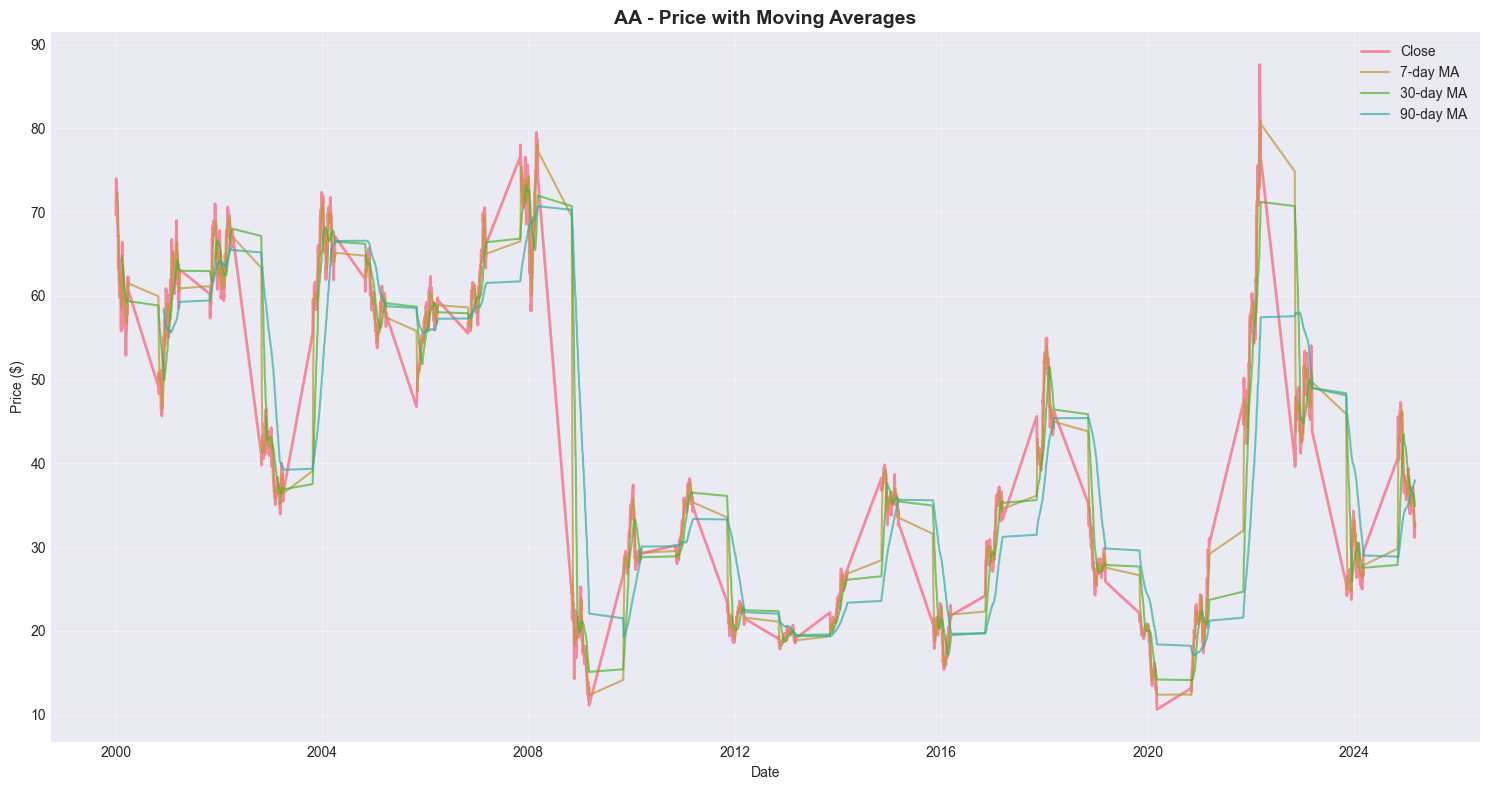

In [175]:
final_merged['MA_7'] = final_merged['Close'].rolling(window=7).mean()
final_merged['MA_30'] = final_merged['Close'].rolling(window=30).mean()
final_merged['MA_90'] = final_merged['Close'].rolling(window=90).mean()

plt.figure(figsize=(15, 8))
plt.plot(final_merged['Date'], final_merged['Close'], label='Close', linewidth=2, alpha=0.8)
plt.plot(final_merged['Date'], final_merged['MA_7'], label='7-day MA', linewidth=1.5, alpha=0.7)
plt.plot(final_merged['Date'], final_merged['MA_30'], label='30-day MA', linewidth=1.5, alpha=0.7)
plt.plot(final_merged['Date'], final_merged['MA_90'], label='90-day MA', linewidth=1.5, alpha=0.7)

plt.title(f'{ticker.upper()} - Price with Moving Averages', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()